In [1]:
# from __future__ import division, print_function # for python < 3.3
import h5py
import sys
import pickle
import numpy as np
import pandas as pd
import lavaburst # Hi-C segmentation tool, see https://github.com/nezar-compbio/lavaburst
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from itertools import islice

%matplotlib inline
sns.set_style('ticks')

/Users/Pushkareva/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Import data

In [24]:
hpy = h5py.File('BG3-1_20kb_IC.hdf5', 'r')
matrix = hpy['4 4'].value
pickle.loads(hpy['genomeIdxToLabel'].value)

{0: '4', 1: 'X', 2: 'M', 3: '3R', 4: '2R', 5: '3L', 6: '2L'}

In [25]:
df = pd.DataFrame(matrix)
df = df.loc[:, (df != 0).any(axis=0)]
df = df.loc[(df != 0).any(axis=1),:]
matrix = np.array(df)

In [27]:
# plt.figure(figsize = [20, 20])
# sns.heatmap(matrix[220:270, 220:270], annot = True, cmap='PuBu')

In [30]:
df = pd.DataFrame(matrix)
df = df.loc[:, (df != 0).any(axis=0)]
df = df.loc[(df != 0).any(axis=1),:]
matrix = np.array(df)
np.fill_diagonal(matrix[1:], np.zeros(matrix.shape[0]-1))
np.fill_diagonal(matrix[:,1:], -np.zeros(matrix.shape[0]-1))

### Normalization by median

In [31]:
import statistics

In [32]:
mtx_medians = matrix.copy()
for i, diag in enumerate(mtx_medians):
    np.fill_diagonal(mtx_medians[i:],
                     [statistics.mean(mtx_medians.diagonal(i))] * len(mtx_medians.diagonal(i)))
    np.fill_diagonal(mtx_medians[:, i:],
                     [statistics.mean(mtx_medians.diagonal(i))] * len(mtx_medians.diagonal(i)))

In [33]:
normalized_mtx = matrix - mtx_medians # разница квадратов, или среднее

In [34]:
mtx_norm = normalized_mtx

In [46]:
mtx = np.power(mtx_norm, 3)

In [47]:
# plt.figure(figsize = [20, 20])
# sns.heatmap(mtx_norm[200:400, 200:400], annot = False, cmap='PuBu')

In [48]:
# mtx1 = np.power(np.array(mtx), 1)
# summs1=[]
# # average_log = []
# for i in range(0, len(mtx1), 10):
#     summs1.append(sum(mtx1.diagonal(i)) + sum(mtx1.diagonal(i+1)) + sum(mtx1.diagonal(i+2))\
#                  + sum(mtx1.diagonal(i+3)) + sum(mtx1.diagonal(i+4)) + + sum(mtx1.diagonal(i+5))\
#                   + sum(mtx1.diagonal(i+6)) + sum(mtx1.diagonal(i+7)) + sum(mtx1.diagonal(i+8)) + \
#                  + sum(mtx1.diagonal(i+9)))
# #     average_log.append(sum(mtx1.diagonal(i))/len(mtx1.diagonal(i)))

In [53]:
# x = [el for el in range(0, len(mtx1), 10)]
# fig = plt.figure(figsize=(10,10))
# plt.plot(x, np.log10(summs1), c='c')
# plt.plot(x, np.log10(summs2), c='m')
# plt.plot(x, np.log10(summs3), c='g')
# plt.plot(x, np.log10(summs4), c='r')
# plt.plot(x, np.log10(summs5), c='y')
# # plt.plot(x, np.log(average_log), c='m')
# fig.savefig('mtx_all_powers_log.png')

In [54]:
# x = [el for el in range(0, len(mtx1))]
# fig = plt.figure(figsize=(10,10))
# plt.plot(x, summs)
# fig.savefig('mtx_first_power.png')

In [55]:
# summs1=[]
# for i in range(len(mtx)):
#     summs1.append(sum(mtx1.diagonal(i)))

In [56]:
# x = [el for el in range(0, len(mtx))]
# plt.figure(figsize=(10,10))
# plt.plot(x, np.log10(summs1))

In [57]:
# for i in range(3, len(mtx)):
#     y = []
#     for j in range(0, len(mtx.diagonal(i))-10, 10):
#         y.append(mtx.diagonal(i)[j]+mtx.diagonal(i)[j+1]+mtx.diagonal(i)[j+2]+mtx.diagonal(i)[j+3]+\
#                  mtx.diagonal(i)[j+4]+mtx.diagonal(i)[j+5]+mtx.diagonal(i)[j+6]+mtx.diagonal(i)[j+7]+\
#                  mtx.diagonal(i)[j+8]+mtx.diagonal(i)[j+9])
# #         print(mtx.diagonal(i)[j]+mtx.diagonal(i)[j+1]+mtx.diagonal(i)[j+2]+mtx.diagonal(i)[j+3]+\
# #              mtx.diagonal(i)[j+4])
#     x = [el for el in range(0, len(mtx.diagonal(i))-10, 10)]
# #     y = mtx.diagonal(i)
#     plt.figure(figsize=(15,20))
#     plt.plot(x, np.log10(y))
    
# plt.show()

# Rubinov's Algorithm

### Галка

In [323]:
res_left = []
for j in range(len(mtx)):
    left = 0
    min_dist = min(j, len(mtx)-j)
    if j < len(mtx)/2:
        for i in range(j-min_dist,j):
            left += mtx[i][j]
        res_left.append(left)
    else:
        for i in range(j-min_dist+1,j):
            left += mtx[i][j]
        res_left.append(left)

In [324]:
# j - строка
res_right = []
for j in range(len(mtx)):
    right = 0
    min_dist = min(j, len(mtx)-j)
    if j < len(mtx)/2:
        for i in range(j, j+min_dist+1):
            right += mtx[j][i]
        res_right.append(right)
    else:
        for i in range(j, j + min_dist):
            right += mtx[j][i]
        res_right.append(right)

### До конца

In [58]:
res_left = np.sum(np.triu(mtx), axis=0)
res_right = np.sum(np.triu(mtx), axis=1)

In [59]:
res = []
for i in range(len(res_left)):
    res.append((res_left[i], res_right[i]))

In [60]:
orientation = [] 
for i in range(len(res)):
    if res[i][0] < res[i][1] or i == 0 or i == 1:
        orientation.append("right")
    elif res[i][0] > res[i][1] or i == len(res)-1 or i == len(res)-2 or i == len(res)-3:
        orientation.append("left")

In [61]:
binary_orientation = []
for i in orientation:
    if i == "right":
        binary_orientation.append(1)
    if i == "left":
        binary_orientation.append(-1)
#     if i == "unknown":
#         binary_orientation.append(0)
print(len(binary_orientation))

1048


# TADs

In [62]:
tads_all = []
tads_left_pos = []
tads_length = []
borders = []
newres = []

In [63]:
len(res) == len(mtx)

True

In [64]:
first_tads = [] # точки границ кластеров (i,i+1) 
first_tads_left_pos = []
first_tads_length = [] 
a = []
resupd = []
n = len(mtx)
tamm = np.zeros((n, n))
numbers = iter(range(len(binary_orientation)))
for i in numbers:
    if binary_orientation[i] == 1 and binary_orientation[i+1] == -1: 
        a.append([i, i + 2])
        tamm[i, i + 1] = 1   
        if res[i][0] + res[i+1][0] > res[i][1] + res[i+1][1]:
            first_tads.append(-1)
        elif res[i][0] + res[i+1][0] < res[i][1] + res[i+1][1]:
            first_tads.append(1)
        
        nres = [res[i][0] + res[i+1][0], res[i][1] + res[i+1][1]] ######
        resupd.append(nres) #######

        first_tads_left_pos.append(i) 
        first_tads_length.append(2)
        next(islice(numbers, 1, 1), None)
    else:

        first_tads.append(binary_orientation[i])
        first_tads_left_pos.append(i) 
        first_tads_length.append(1)
        resupd.append(res[i])  #########
        
newres.append(resupd)

tads_all.append(binary_orientation)
tads_all.append(first_tads)
borders.append(a)
tads_left_pos.append(first_tads_left_pos)
tads_length.append(first_tads_length)

In [67]:
max_level = 0
for level in range(1000):
    tads = [] # границы кластеров (i, i+1) 
    tads_left = [] 
    tads_len = [] 
    border = []
    resupd = []
    numbers = iter(range(len(tads_all[level+1])-1))
    if borders[level][0][0] == 0 and borders[level][0][1] == len(mtx):
        max_level = level
        print('Highest level', max_level)
        break
    for i in numbers:
        print(level, i)
        if tads_all[level+1][i] == 1 and tads_all[level+1][i+1] == -1:
            border.append([tads_left_pos[level][i], tads_left_pos[level][i] +\
                           tads_length[level][i] + tads_length[level][i+1]])
            tamm[tads_left_pos[level][i]][tads_left_pos[level][i] +\
                                          tads_length[level][i] + tads_length[level][i+1]-1] = level + 2
            if newres[level][i][0] + newres[level][i+1][0] > newres[level][i][1] + newres[level][i+1][1]:
                tads.append(-1)
            elif newres[level][i][0] + newres[level][i+1][0] < newres[level][i][1] + newres[level][i+1][1]:
                tads.append(1)
            nres = [newres[level][i][0] + newres[level][i+1][0], newres[level][i][1] + newres[level][i+1][1]] ######
            resupd.append(nres)
            
            tads_left.append(tads_left_pos[level][i]) 
            tads_len.append(tads_length[level][i] + tads_length[level][i+1]) 
            next(islice(numbers, 1, 1), None)
            
        else:
            tads.append(tads_all[level+1][i])
            tads_left.append(tads_left_pos[level][i]) 
            tads_len.append(tads_length[level][i])
            resupd.append(newres[level][i])
    
    newres.append(resupd)
    tads_all.append(tads)
    borders.append(border)
    tads_left_pos.append(tads_left)
    tads_length.append(tads_len)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 14
0 15
0 16
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 48
0 49
0 50
0 51
0 53
0 54
0 55
0 56
0 57
0 58
0 60
0 61
0 62
0 63
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 85
0 87
0 89
0 90
0 91
0 93
0 94
0 96
0 97
0 98
0 99
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 111
0 113
0 114
0 115
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 125
0 127
0 128
0 130
0 131
0 132
0 134
0 135
0 136
0 137
0 139
0 140
0 141
0 142
0 143
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 154
0 155
0 156
0 157
0 158
0 159
0 161
0 162
0 164
0 165
0 166
0 168
0 169
0 170
0 171
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 181
0 182
0 183
0 184
0 185
0 186
0 187
0 188
0 190
0 191
0 192
0 194
0 195
0 196
0 197
0 198
0 199
0 200
0 201
0 203
0 204
0 205
0 207
0 208
0 209
0 211
0 212
0 213
0 215
0 216
0 217

2 80
2 81
2 82
2 83
2 84
2 85
2 86
2 87
2 89
2 90
2 91
2 92
2 93
2 94
2 96
2 97
2 98
2 99
2 100
2 101
2 102
2 103
2 104
2 105
2 106
2 107
2 109
2 110
2 111
2 112
2 113
2 114
2 116
2 117
2 119
2 120
2 121
2 122
2 123
2 124
2 125
2 127
2 128
2 129
2 131
2 132
2 133
2 134
2 135
2 136
2 137
2 138
2 139
2 140
2 141
2 143
2 144
2 145
2 146
2 147
2 149
2 150
2 151
2 152
2 154
2 156
2 157
2 158
2 159
2 161
2 162
2 163
2 165
2 166
2 168
2 169
2 170
2 171
2 173
2 174
2 175
2 176
2 177
2 178
2 179
2 180
2 181
2 182
2 183
2 185
2 186
2 187
2 189
2 190
2 192
2 193
2 194
2 195
2 196
2 197
2 199
2 200
2 201
2 202
2 203
2 204
2 205
2 206
2 208
2 209
2 210
2 211
2 213
2 214
2 215
2 216
2 217
2 218
2 219
2 220
2 221
2 223
2 224
2 225
2 227
2 228
2 229
2 230
2 232
2 233
2 234
2 235
2 237
2 238
2 240
2 241
2 242
2 244
2 245
2 246
2 248
2 250
2 251
2 252
2 253
2 254
2 255
2 257
2 258
2 259
2 260
2 261
2 262
2 263
2 265
2 266
2 267
2 268
2 269
2 270
2 271
2 272
2 273
2 274
2 276
2 277
2 278
2 279
2 280
2 28

6 125
6 127
6 128
6 129
6 130
6 131
6 133
6 134
6 135
6 137
6 138
6 139
6 140
6 142
6 143
6 144
6 145
6 147
6 148
6 149
6 150
6 151
6 152
6 153
6 155
6 156
6 157
6 158
6 159
6 160
6 161
6 162
6 163
6 165
6 166
6 167
6 168
6 169
6 170
6 171
6 172
6 173
6 174
6 175
6 176
6 177
6 179
6 180
6 181
6 182
6 183
6 184
6 185
6 186
6 187
6 188
6 189
6 190
6 191
6 192
6 193
6 194
6 195
6 196
6 197
6 199
6 200
6 201
6 202
6 204
6 205
6 206
6 207
6 208
6 209
6 210
6 211
6 212
6 213
6 215
6 216
6 217
6 218
6 219
6 220
6 221
6 222
6 223
6 224
6 226
6 227
6 228
6 229
6 230
6 231
6 232
6 234
6 236
6 237
6 238
6 239
6 240
6 242
6 243
6 245
6 246
6 247
6 248
6 250
6 251
6 252
6 253
6 254
6 256
6 257
6 258
6 259
6 260
6 261
6 262
6 263
6 264
6 265
6 266
6 267
6 268
6 269
6 270
6 272
6 273
6 274
6 275
6 276
6 277
6 278
6 280
6 281
6 282
6 283
6 284
6 285
6 286
6 287
6 288
6 290
6 291
6 292
6 293
6 294
6 295
6 296
6 298
6 299
6 300
6 301
6 302
6 303
6 305
6 306
6 308
6 309
6 310
6 312
6 313
6 314
6 315
6 31

16 54
16 55
16 56
16 57
16 59
16 60
16 62
16 63
16 65
16 66
16 67
16 68
16 69
16 70
16 71
16 72
16 73
16 75
16 76
16 77
16 78
16 79
16 80
16 82
16 83
16 84
16 85
16 86
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 11
17 12
17 13
17 14
17 15
17 16
17 17
17 18
17 19
17 20
17 22
17 23
17 24
17 25
17 26
17 27
17 28
17 29
17 30
17 31
17 32
17 33
17 34
17 35
17 36
17 38
17 39
17 40
17 42
17 43
17 45
17 46
17 48
17 49
17 50
17 51
17 52
17 54
17 56
17 57
17 58
17 59
17 60
17 61
17 62
17 63
17 65
17 66
17 67
17 68
17 69
17 70
17 72
17 73
17 74
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 10
18 11
18 12
18 13
18 14
18 15
18 16
18 17
18 18
18 19
18 20
18 21
18 22
18 23
18 24
18 25
18 26
18 27
18 28
18 29
18 30
18 31
18 32
18 33
18 35
18 36
18 37
18 39
18 40
18 41
18 43
18 44
18 45
18 46
18 48
18 49
18 50
18 51
18 52
18 53
18 54
18 56
18 57
18 58
18 59
18 60
18 62
18 63
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 9
19 10
19 11
19 12
19 13
19 14
19 15
19 16
19 17
19 18
19 19
19 20
19 21
19

IndexError: list index out of range

In [70]:
tads_length[36][6]

1

In [78]:
borders[33][5]

IndexError: list index out of range

# Visualisation

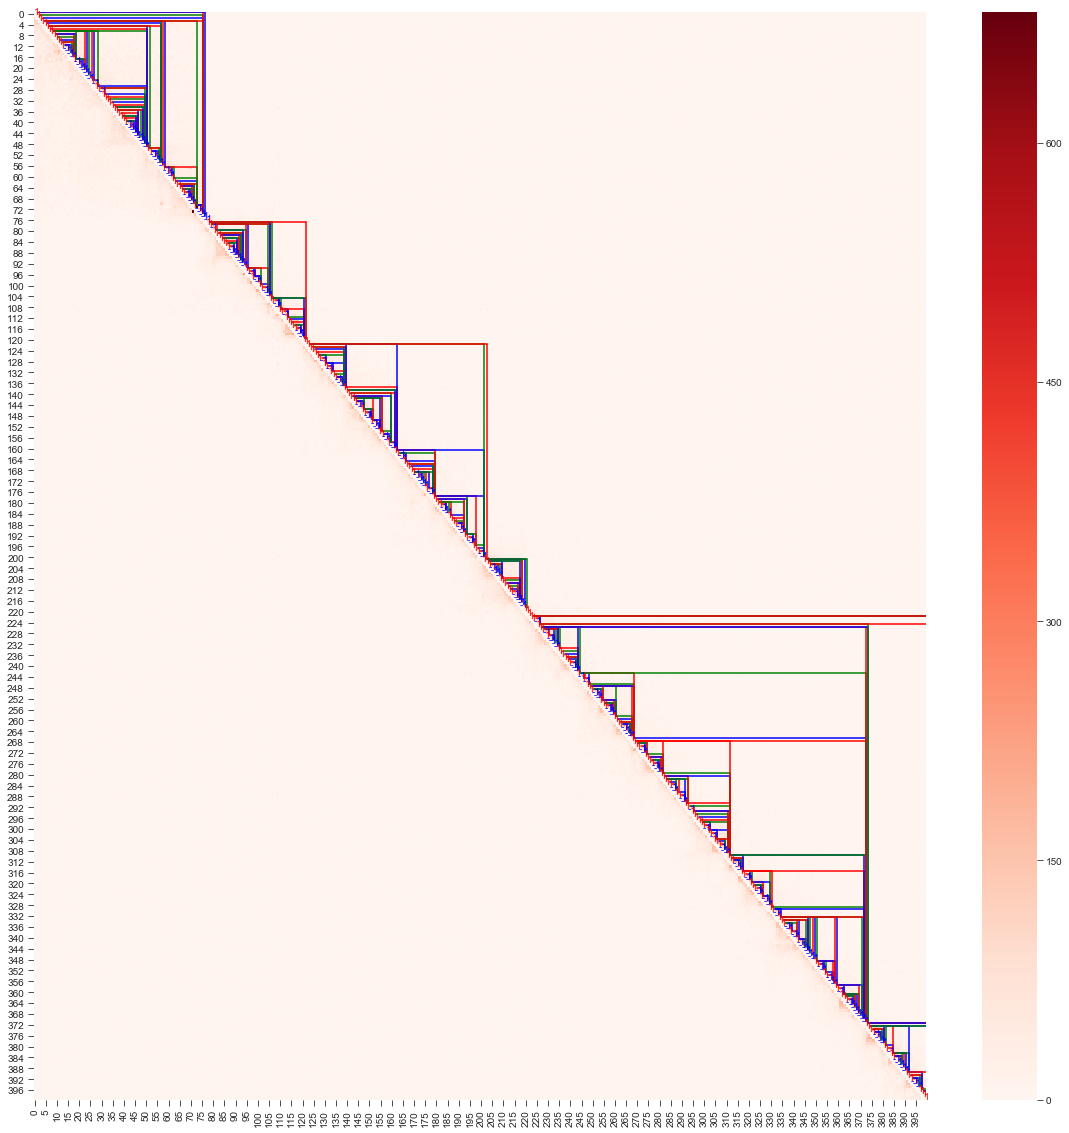

In [66]:
startmtx = 0 #901 #10
endmtx = 400 #300
def mtxplot(lvl, color):
    for j in range(len(lvl)):
        bgn = lvl[j][0] - startmtx
        end = lvl[j][1] - startmtx
        plt.plot([bgn +2, end+2], [bgn, bgn], color=color) # plt.plot(xs, ys, color)
        plt.plot([end+2, end+2], [bgn, end], color=color)
        
plt.figure(figsize=(20, 20))
sns.heatmap(matrix[:400, :400], cmap='Reds')

for i in range(startmtx, endmtx):
    val = binary_orientation[i]
    plt.text(i - startmtx, i + 0.8 - startmtx, val, {'color':'red' if val>0 else 'blue'})

if len(borders) % 3 == 0:
    colors = ['red', 'blue', 'green'] * int(len(borders) / 3)
else:
    colors = ['red', 'blue', 'green'] * int(len(borders) / 3)
#     colors.append(['orange','blue','green'][: len(borders) % 3])

for lvl, color in zip(borders, colors):
    mtxplot(lvl, color)
# plt.savefig('mtx_crop_1degree.pdf', format='pdf')  # , dpi=1000)

In [94]:
def plot_heatmap_triu(m):
    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(20,10), gridspec_kw={'height_ratios':[1,1]})
    #, sharex=True, gridspec_kw={'height_ratios':[3,1]})

    rotated = rotate(np.triu(np.nan_to_num(m)), angle=45)
    ax0.imshow(rotated[:(int(rotated.shape[0]/2)), :], cmap='PuBu', aspect='auto')
    ax0.set_ylim(70, 0)
    ax0.set_xlim([0, 50])
    ax0.spines['bottom'].set_visible(False)
    
    ax1.plot([i for i in range(len(y))], y)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_xlim([0, 40])
    
    plt.subplots_adjust(hspace=0)
    plt.show()

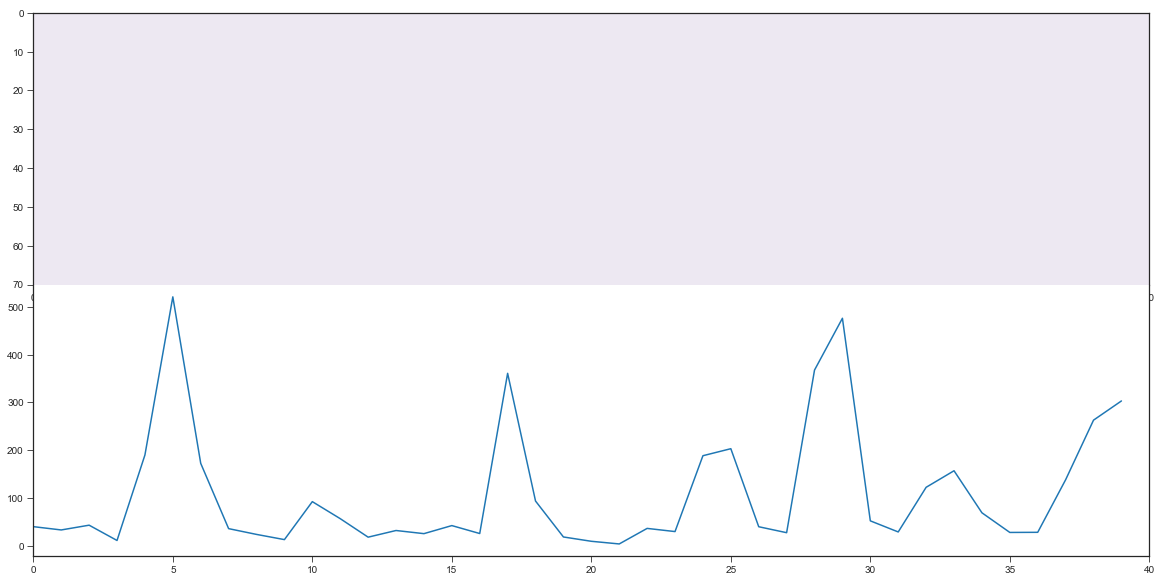

In [95]:
plot_heatmap_triu(mtx)

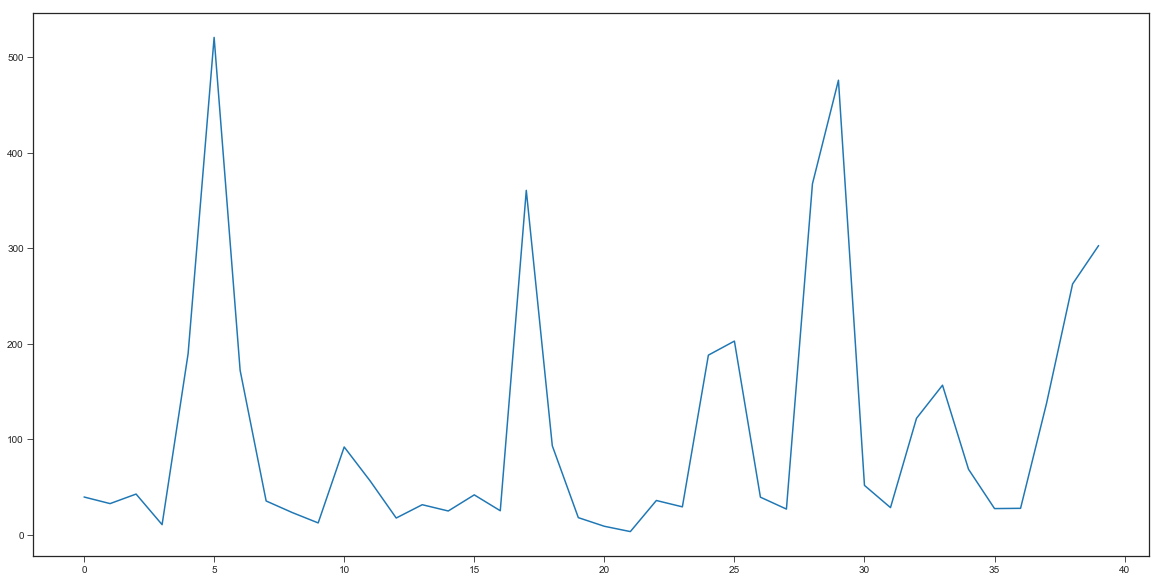

In [97]:
plt.figure(figsize=(20,10), frameon=False)
plt.plot([i for i in range(len(y))], y)

In [78]:
from scipy.ndimage import rotate

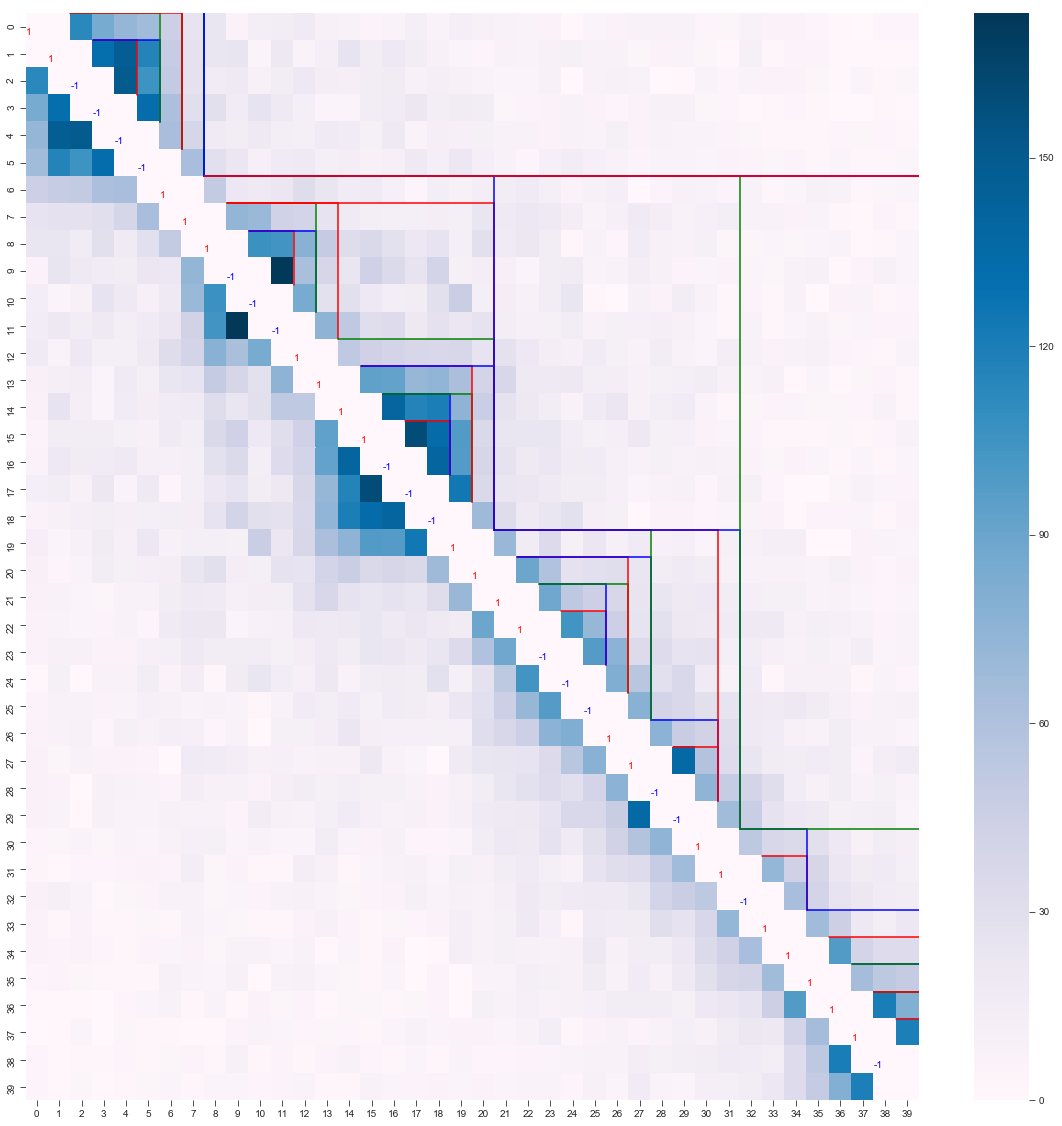

In [98]:
startmtx = 261 #901 #10
endmtx = 300 #300
def mtxplot(lvl, color):
    for j in range(len(lvl)):
        bgn = lvl[j][0] - startmtx
        end = lvl[j][1] - startmtx
        plt.plot([bgn+2, end+2], [bgn, bgn], color=color) # plt.plot(xs, ys, color)
        plt.plot([end+2, end+2], [bgn, end], color=color)
        
plt.figure(figsize=(20,20))
sns.heatmap(mtx[260:300, 260:300], cmap='PuBu')

for i in range(startmtx, endmtx):
    val = binary_orientation[i]
    plt.text(i - startmtx, i + 0.8 - startmtx, val, {'color':'red' if val>0 else 'blue'})

if len(borders) % 3 == 0:
    colors = ['red','blue','green'] * int(len(borders) / 3)
else:
    colors = ['red','blue','green'] * int(len(borders) / 3)
#     colors.append(['orange','blue','green'][: len(borders) % 3])

for lvl, color in zip(borders, colors):
    mtxplot(lvl, color)
# plt.title('Hierarchical tree for S2 cell line (700 to 800 bins slice), chr2L',fontsize='18')
plt.savefig('mtx_4degree.pdf', format='pdf', dpi=1000)

In [ ]:
# correlation between rubinov vector for trees and ctcf